In [2]:
%matplotlib inline

from modsim import *

In [3]:
def make_system(beta, gamma, death_rate):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0, D=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma, death_rate=death_rate)

In [4]:
def plot_results(S, I, R, D, Q=None):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    plot(D, color='black', label="Dead")
    if Q is not None:
        plot(Q, color='purple', label="Quarantine")
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [5]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [6]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for i in linrange(t0, t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
    
    system.results = frame
    return frame

In [7]:
def update1(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i, r, d = state

    infected = beta * i * s    
    recovered = gamma * i
    deaths = i * death_rate
    
    s -= infected
    i += infected - recovered - deaths
    r += recovered
    d += deaths
    
    return State(S=s, I=i, R=r, D=d)

0.041915473577421702

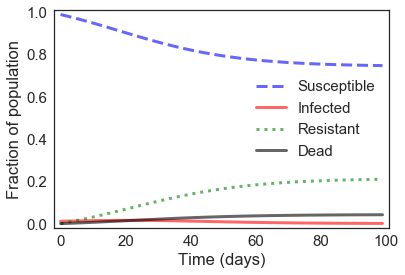

In [8]:
sird = make_system(0.333, 0.25, 0.05)
frame = run_simulation(sird, update1)

plot_results(frame.S, frame.I, frame.R, frame.D)
frame.D[sird.t_end]

0.030205325019757253

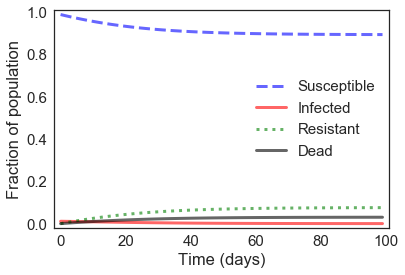

In [9]:
sird = make_system(0.333, 0.25, 0.1)
frame = run_simulation(sird, update1)

plot_results(frame.S, frame.I, frame.R, frame.D)
frame.D[sird.t_end]

0.016598022988869483

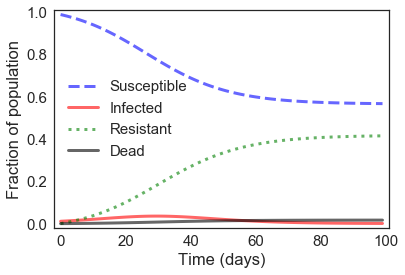

In [10]:
sird = make_system(0.333, 0.25, 0.01)
frame = run_simulation(sird, update1)

plot_results(frame.S, frame.I, frame.R, frame.D)
frame.D[sird.t_end]

0.01206683981192856

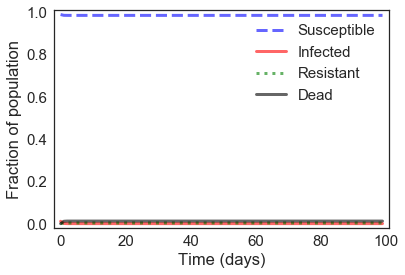

In [11]:
sird = make_system(0.333, 0.25, 1)
frame = run_simulation(sird, update1)

plot_results(frame.S, frame.I, frame.R, frame.D)
frame.D[sird.t_end]

In [34]:
def sweep_death(death_array):
    sweep = SweepSeries()
    for d in death_array:
        sird = make_system(0.6, 0.1, d)
        frame = run_simulation(sird, update1)
        sweep[d] = frame.D[t_end]
    return sweep

0.18


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


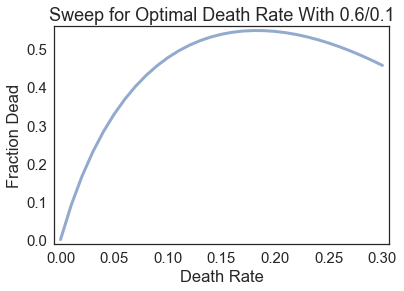

In [64]:
death_array = linspace(0, 0.3, 31)
sweep = sweep_death(death_array)
plot(sweep)
decorate(xlabel= 'Death Rate', ylabel='Fraction Dead', title = 'Sweep for Optimal Death Rate With 0.6/0.1')
m = sweep.idxmax()
print(m)

In [46]:
def make_system_developing(beta, gamma, death_rate, q_rate):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=95, I=5, R=0, D=0, Q=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma, death_rate=death_rate, q_rate=q_rate)

In [10]:
def make_system_developed(beta, gamma, death_rate):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=99, I=1, R=0, D=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma, death_rate=death_rate)

In [40]:
def make_systems(beta, gamma, death_rate, q_rate, n, n_d):
    a = make_system_developing(beta, gamma, death_rate, q_rate)
    d_gamma = gamma*n
    d_death = death_rate*n_d
    b = make_system_developed(beta, d_gamma, d_death) 
    return a, b

In [41]:
a, b = make_systems(0.6, 0.1, 0.1, 0.05, 1.5, 0.5)
b.gamma

0.15000000000000002

In [29]:
a.gamma

0.25

In [57]:
def update2(state, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i, r, d, q = state

    infected = beta * i * s    
    recovered_i = gamma * i
    recovered_q = gamma * q 
    deaths_i = i * death_rate
    deaths_q = q * death_rate * 0.9
    quarantines = i * q_rate 
    
    s -= infected
    i += infected - recovered_i - deaths_i - quarantines 
    r += recovered_i + recovered_q 
    d += deaths_i + deaths_q 
    q += quarantines - recovered_q - deaths_q # 0
    
    return State(S=s, I=i, R=r, D=d, Q=q)

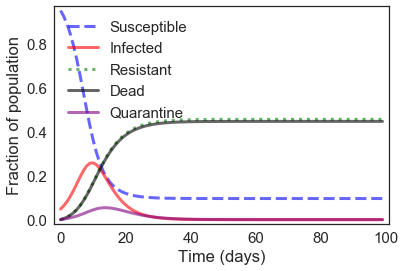

In [42]:
frame_a = run_simulation(a, update2)
plot_results(frame_a.S, frame_a.I, frame_a.R, frame_a.D, frame_a.Q)

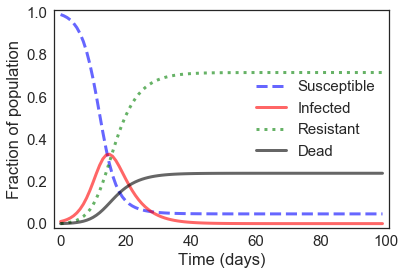

In [18]:
frame_b = run_simulation(b, update1)
plot_results(frame_b.S, frame_b.I, frame_b.R, frame_b.D)

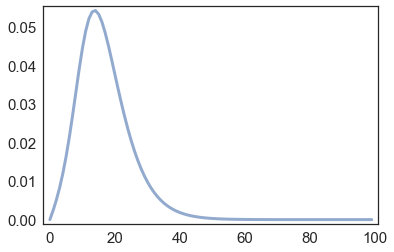

In [62]:
plot(frame_a.Q)

In [50]:
max(frame_b.D)

0.23848948885525292

In [47]:
def sweep_qrate(q_array):
    q_sweep = SweepSeries()
    for q in q_array:
        system = make_system_developing(0.6, 0.1, 0.1, q)
        frame = run_simulation(system, update2)
        q_sweep[system.q_rate] = max(frame.D)
    return q_sweep

In [58]:
q_array = linspace(0, 0.3, 31)
q_sweep = sweep_qrate(q_array)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


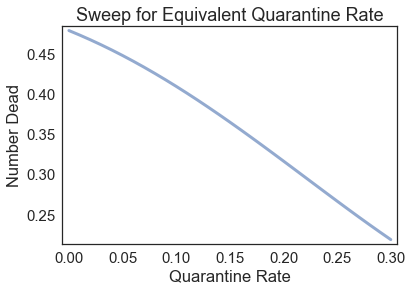

In [70]:
plot(q_sweep)
decorate(xlabel='Quarantine Rate',
         ylabel='Number Dead',
        title='Sweep for Equivalent Quarantine Rate')

In [60]:
q_sweep

,value
0.00,0.478433
0.01,0.472836
0.02,0.466939
0.03,0.460736
0.04,0.454228
0.05,0.447415
0.06,0.440304
0.07,0.432902
0.08,0.425218
0.09,0.417263


In [67]:
a, b = make_systems(0.6, 0.1, 0.1, 0.28, 1.5, 0.5)
frame_a = run_simulation(a, update2)
frame_b = run_simulation(b, update1)

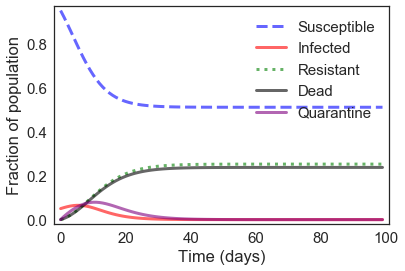

In [68]:
plot_results(frame_a.S, frame_a.I, frame_a.R, frame_a.D, frame_a.Q)

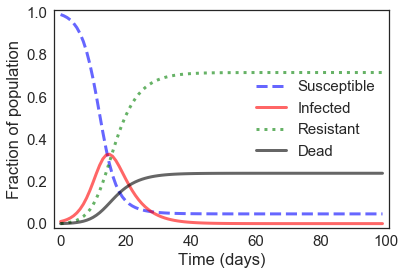

In [69]:
plot_results(frame_b.S, frame_b.I, frame_b.R, frame_b.D)

In [71]:
a, b = make_systems(0.6, 0.1, 0.1, 0, 1.5, 0.5)
frame_a = run_simulation(a, update2)
frame_b = run_simulation(b, update1)

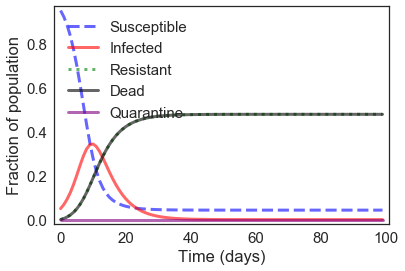

In [72]:
plot_results(frame_a.S, frame_a.I, frame_a.R, frame_a.D, frame_a.Q)